In [31]:
import numpy as np
from scipy.special import gammaln
from scipy.integrate import quad
from scipy.special import binom as sp_binom
# import quadpy

from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, HBox, VBox, Output, FloatSlider
# from IPython.display import display

import os, sys
sys.path.append( os.path.dirname( os.path.abspath('') ) )

from inference.BayesModel import *
from inference.utils.utils import adaptive_integration, p_nu, f
from empirical.readData import *

%matplotlib ipympl

In [32]:
def adaptive_integration(f,x_lower,x_upper,args,eps_pow=-8,eps_thr=-4):
    while True:
        if eps_pow==eps_thr:
            # print('tolerance too high - breaking!')
            return None

        try:
            res,err = quad(f,x_lower,x_upper,args=args,epsabs=10**eps_pow, epsrel=10**eps_pow,points=np.logspace(-3,0,4))

            break
        except:
            # print(f'error in integration with tolerance 10^{eps_pow}')
            eps_pow += 1
    return res


In [33]:
def p_nu_single(NU,gamma,delta,nu_max,log=False):

    if not isinstance(NU,np.ndarray):
        NU = np.array(NU)
    NU_mask = NU > 0
    #NU_mask = np.log(NU/nu_max)<0
    p = np.zeros_like(NU)
    NU_scaled = NU[NU_mask] / nu_max
    #NU_scaled = NU / nu_max
    
    if log:
        return - np.log( nu_max / gamma * np.sqrt( -np.pi * np.log( NU_scaled ) ) ) - delta**2 / 2 + \
            ( gamma**2 - 1 ) * np.log( NU_scaled ) + \
            np.log( np.cosh( gamma * delta * np.sqrt( -2 * np.log( NU_scaled ) ) ) )
    else:
        p[NU_mask] = gamma / ( nu_max * np.sqrt( -np.pi * np.log( NU_scaled ) ) ) * \
            np.exp( - delta**2/2.) * ( NU_scaled )**(gamma**2 - 1) * \
            np.cosh( gamma * delta * np.sqrt( -2 * np.log( NU_scaled ) ) )
        p[NU==0] = 0 if gamma > 1 else np.inf
    return p

def p_nu(NU,p,two_pop=False,log=False):

    if not 'weight_dark' in p.keys():
        p['weight_dark'] = 0.5
    if two_pop:
        return (p['weight_dark'] * p_nu_single(NU,p['gamma_dark'],p['delta_dark'],p['nu_max'],log=log) + \
                (1-p['weight_dark']) * p_nu_single(NU,p['gamma'],p['delta'],p['nu_max'],log=log))
    else:
        return p_nu_single(NU,p['gamma'],p['delta'],p['nu_max'],log=log)

def poisson_spikes(nu,N_AP,T,log=False):
    ## using the gamma-function to obtain log(N!) = gammaln(N+1)
    #print('poisson:',N_AP*np.log(nu*T) - gammaln(N_AP+1) - nu*T)
    if log:
        return N_AP*np.log(nu*T) - gammaln(N_AP+1) - nu*T        
    else:
        return np.exp(N_AP*np.log(nu*T) - gammaln(N_AP+1) - nu*T)


def f(NU,p,N_AP,T,two_pop=False,log=False):
    '''
        calculates the probability to observe N_AP action potentials in any neuron, 
        given the underlying firing rate distribution and poisson firing
    '''
    #print('log:',log)
    if log:
        #print(f'p_nu:',p_nu(NU,p,two_pop=two_pop,log=log))
        #print(f'poisson:',poisson_spikes(NU,N_AP,T,log=log))
        p = np.exp(p_nu(NU,p,two_pop=two_pop,log=log) + poisson_spikes(NU,N_AP,T,log=log))
        #print(f'total: ', p)
        #print('shape:',p.shape)
        return p
        #return np.exp(p_nu(NU,p,two_pop=two_pop,log=log) + poisson_spikes(NU,N_AP[:,np.newaxis],T,log=log))
    else:
        return p_nu(NU,p,two_pop=two_pop,log=log) * poisson_spikes(NU,N_AP,T,log=log)


## Plot $p(N_{AP})$

1. from $p(\nu)$, discretized at integer spike times
       probability to observe neuron with at rate $\nu$ / with spike number $N_{AP} T$ is given by $\frac{p(\nu)}{T}$

interactive(children=(IntSlider(value=60, description='T', min=1), FloatSlider(value=1.0, description='rateWnt…

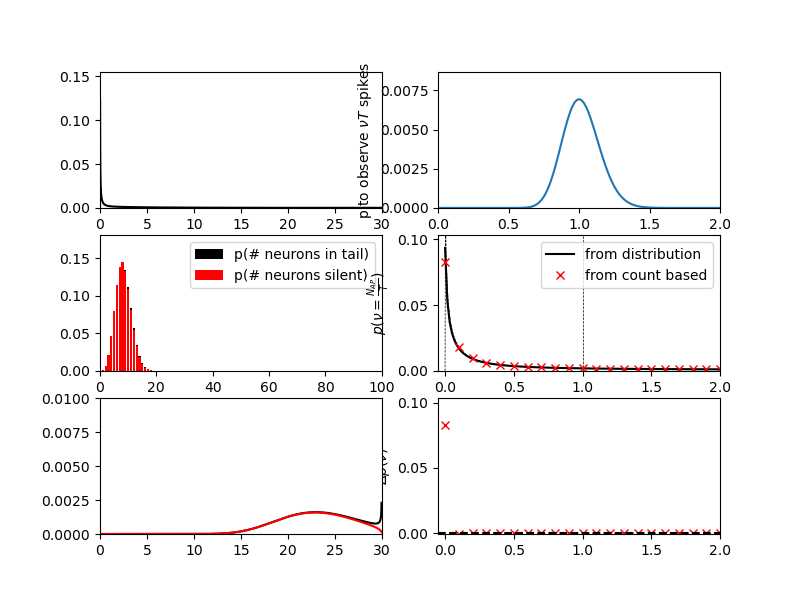

In [34]:
import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("default")

fig = plt.figure(figsize=(8,6))

ax_full = fig.add_subplot(321)
ax_k_distr = fig.add_subplot(323)

ax_single = fig.add_subplot(322)
ax_p_N_AP = fig.add_subplot(324)
ax_p_N_AP_error = fig.add_subplot(326)
#fig,ax = plt.subplots(1,2,figsize=(12,4))
#ax[0][0].axvline(1.,linestyle='--',color='k')

# nNeurons = 100
h_p_full, = ax_full.plot(0,0,'k-',label='from distribution')
# ax_full.set_xscale('log')
# h_k_rects_tail = ax_k_distr.bar(range(nNeurons),np.zeros(nNeurons),facecolor='k',label='p(# neurons in tail)')
# h_k_rects_silent = ax_k_distr.bar(range(nNeurons),np.zeros(nNeurons),facecolor='r',label='p(# neurons silent)')
ax_k_distr.legend()


h_ax, = ax_single.plot(0, 0)#,label=f'$T={T}$')
plt.setp(ax_single,xlabel='neuron firing rate',ylabel='p to observe $\\nu T$ spikes')

h_rateMarker = ax_p_N_AP.axvline(0.,linestyle='--',color='k',linewidth=0.5)

### 
steps = 20

h_p_N_AP_cont, = ax_p_N_AP.plot(0,0,'k-',label='from distribution')
h_p_N_AP_full, = ax_p_N_AP.plot(0,0,'k--',linewidth=0.5)
h_p_N_AP, = ax_p_N_AP.plot(0,0,'xr',label='from count based')
plt.setp(ax_p_N_AP,xlim=[-0.05,2],ylim=[0,1.05],ylabel='$p(\\nu = \\frac{N_{AP}}{T})$')
ax_p_N_AP.legend()

h_p_N_AP_error, = ax_p_N_AP_error.plot( 0,0, 'xr' )
ax_p_N_AP_error.axhline(0,linestyle='--',color='k')
ax_p_N_AP_error.set_xlim([-0.05,2])
plt.setp(ax_p_N_AP_error,ylabel='$\\Delta p(\\nu)$')


ax_p_extreme = fig.add_subplot(325)
h_p_extreme, = ax_p_extreme.plot(0,0,'k-')
h_p_extreme_shift, = ax_p_extreme.plot(0,0,'r-')


gamma_slider = FloatSlider(value=1.5,min=0.,max=5.)
delta_slider = FloatSlider(value=4.,min=1.,max=10.)
nu_max_slider = FloatSlider(value=25.,min=10.,max=100.)

#param_control = VBox([gamma_slider,delta_slider,nu_max_slider])

@interact(T=(1,100),rateWnt=(0.,4.),gamma=(0.,4.),delta=(1.,20.),nu_max=(15.,100.),delta_dark=(1.,20.),nNeurons=(1,1000))
def update_p_N_AP(T=60,rateWnt=1.,gamma=1.8,delta=3.5,nu_max=30.,delta_dark=6.1,nNeurons=100,center=False,correct=False):
    
    gamma_dark = gamma
    # delta_dark = gamma_dark/gamma * delta
    params = {'gamma':gamma, 'delta':delta, 'nu_max':nu_max,'gamma_dark':gamma_dark,'delta_dark':delta_dark}
    
    N_max = int(np.ceil(nu_max*T))
    nu_array = np.linspace(0,N_max/T,N_max+1)
    nu_full = np.linspace(0,nu_max,10001)

    p_full = p_nu(nu_full,params,two_pop=True) / T
    # p_full = p_nu_single(nu_full,**params) / T

    # print(p_full)
    # p_full_sum = p_full[1:-1].sum()
    # print(f'{p_full_sum=}')

    ax_k_distr.clear()

    h_p_full.set_data(nu_full,p_full)
    plt.setp(ax_full,xlim=[0,nu_max],ylim=[0,1.25*np.nanmax(p_full)])
    # plt.setp(ax_full,xlim=[10**(-4),2*10**1],ylim=[0,1.25*np.nanmax(p_full)])


    p_spike_count_in_empirical_range = adaptive_integration(p_nu,0,nu_max/2.,
                    args=(params))
    
    # print(f'{p_spike_count_in_empirical_range=}')

    p_spike_in_tail = 1-p_spike_count_in_empirical_range

    k = np.arange(0,nNeurons)
    binom = sp_binom(nNeurons,k)

    logp_tail = np.log(binom) + k*np.log(p_spike_in_tail) + (nNeurons-k)*np.log(1-p_spike_in_tail)
    p_tail = np.exp(logp_tail)


    ax_k_distr.bar(range(nNeurons),p_tail,facecolor='k',label='p(# neurons in tail)')


    offset = np.diff(nu_array)[0]/2. if center else 0.
    
    N_max_steps = np.ceil(2*T/steps)*steps
    rateWnt_array = np.linspace(0,N_max_steps/T,steps+1)

    ## update plot showing probability to observe N_AP spikes
    y_vals = f(nu_array,p=params,N_AP=np.array([rateWnt*T]),T=T)
    yy = y_vals[np.isfinite(y_vals)]
    
    h_ax.set_data(nu_array,y_vals)
    h_rateMarker.set_xdata(rateWnt)

    plt.setp(ax_single,xlim=[0,2],ylim=[0,1.25*np.max(yy)])


    ## count based
    p_N_AP = np.zeros(steps+1)
    for r,rateWnt in enumerate(rateWnt_array):

        p_N_AP[r] = adaptive_integration(f,0,params['nu_max'],
            args=(params,np.array([rateWnt*T]),T,True)
        )

    logp_silent = np.log(binom) + k*np.log(p_N_AP[0]) + (nNeurons-k)*np.log(1-p_N_AP[0])
    p_silent = np.exp(logp_silent)
    ax_k_distr.bar(range(nNeurons),p_silent,facecolor='r',label='p(# neurons silent)')


    # logp_lowactive = np.log(binom) + k*np.log(p_N_AP[1]) + (nNeurons-k)*np.log(1-p_N_AP[1])
    # p_lowactive = np.exp(logp_lowactive)
    # ax_k_distr.bar(range(nNeurons),p_lowactive,facecolor='g',label='p(# neurons lowactive)')
    
    
    plt.setp(ax_k_distr,xlim=[0,nNeurons],ylim=[0,np.max([p_silent.max(),p_tail.max()])*1.25])

    ax_k_distr.legend()
    ## continuous
    # p_N_AP_cont = p_nu_single(nu_array + offset,**params) / T
    
    # p_N_AP_cont = p_nu(nu_array + offset,params,two_pop=True) / T
    p_N_AP_cont = (p_nu(nu_array[:-1],params,two_pop=True) + p_nu(nu_array[1:],params,two_pop=True)) / (2*T)

    p_N_AP_cont_points = p_nu(rateWnt_array + offset,params,two_pop=True) / T

    # print(p_N_AP_cont)
    # print(p_N_AP_cont[1:-1].sum())

    if correct:
        p_N_AP_cont[0] = 1 - p_N_AP_cont[1:-1].sum()
        p_N_AP_cont_points[0] = 1 - p_N_AP_cont[1:-1].sum()

    yy = p_N_AP_cont[np.isfinite(p_N_AP_cont)]
    plt.setp(ax_p_N_AP,ylim=[0,1.25*np.max(p_N_AP)])
    
    h_p_N_AP.set_data(rateWnt_array,p_N_AP)
    h_p_N_AP_cont.set_data(nu_array[:-1],p_N_AP_cont)
    h_p_N_AP_full.set_data(nu_full,p_full)
    
    
    ### calculate error
    # p_N_AP_cont = p_nu_single(rateWnt_array + offset,**params) / T
    

    p_N_AP_error = p_N_AP - p_N_AP_cont_points
    h_p_N_AP_error.set_data(rateWnt_array, p_N_AP_error)
    plt.setp(ax_p_N_AP_error,ylim=[p_N_AP_error.min()*1.25,p_N_AP_error.max()*1.25])



    ## calculate the CDF and thus maximum value distribution
    if not correct:
        p_N_AP_cont[0] = 1 - p_N_AP_cont[1:-1].sum()
    p_N_AP_cum = np.cumsum(p_N_AP_cont)
    p_N_AP_cum = np.pad(p_N_AP_cum**nNeurons,(1,0),mode='constant',constant_values=0)

    p_extreme = np.diff(p_N_AP_cum)
    p_extreme_edit = p_extreme * (1 - 1./(nu_max-nu_array[:-1]+1)**2)
    # p_extreme *= nu_max*T/p_extreme.sum()

    h_p_extreme.set_data(nu_array[:-1],p_extreme)
    h_p_extreme_shift.set_data(nu_array[:-1],p_extreme_edit)

    # plt.setp(ax_p_extreme,xlim=[0,nu_max],ylim=[0,1.25*np.max(p_extreme[np.isfinite(p_extreme)])])
    plt.setp(ax_p_extreme,xlim=[0,nu_max],ylim=[0,0.01])
    print(f'{p_extreme[:-1].sum()=}')

    fig.canvas.draw_idle()





In [29]:
ref_values = {
    'gamma': 1.5,
    'delta': 4.5,
    'nu_max': 25.,
    'T': 10,
    'N': 50
}
mP = ModelParams(mode='artificial',**ref_values)
BM, results, sampler = run_sampling(mP)



0.3028881141416137 0.004052847345693511 1.1226697609075278
inferred parameters: options['rateWnt']=0.3028881141416137, options['tau_I']=[0.004052847345693511], options['alpha_0']=0.025221391927438126


[1.9961257718047305, 6.634121979108288, 37.174899884430495]


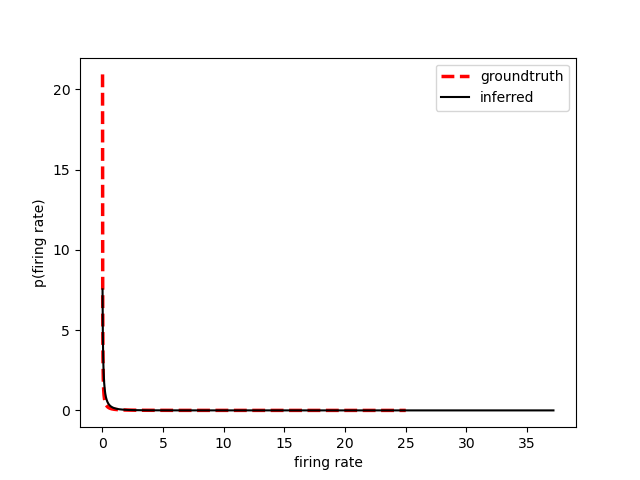

In [30]:
print(results['posterior']['mean'])

nu_array = np.linspace(0,50,10001)
fig = plt.figure()

ax = fig.add_subplot(111)
ax.plot(nu_array,p_nu(nu_array,ref_values['gamma'],ref_values['delta'],ref_values['nu_max']),'r--',linewidth=2.5,label='groundtruth')
ax.plot(nu_array,p_nu(nu_array,*results['posterior']['mean']),'k-',label='inferred')

ax.legend()
plt.setp(ax,xlabel='firing rate',ylabel='p(firing rate)')
plt.show(block=False)


interactive(children=(FloatSlider(value=1.9, description='gamma', max=4.0), FloatSlider(value=3.5, description…

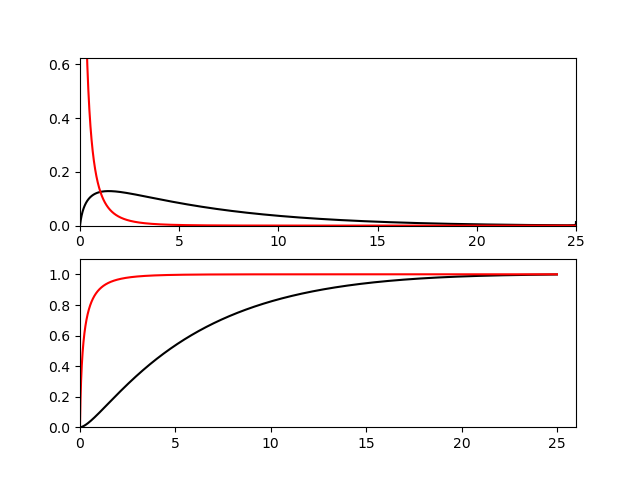

In [5]:
fig = plt.figure()


### plot two-mode distribution with sliders for gamma, delta, nu_max, and gamma_dark
ax_nu = fig.add_subplot(211)
ax_nu_cum = fig.add_subplot(212)

h_p_nu, = ax_nu.plot(0,0,'k')
h_p_nu_dark, = ax_nu.plot(0,0,'r')

h_p_nu_cum, = ax_nu_cum.plot(0,0,'k')
h_p_nu_dark_cum, = ax_nu_cum.plot(0,0,'r')


@interact(gamma=(0.,4.),delta=(1.,10.),nu_max=(15.,100.),delta_dark=(0.,10.))
def update_plot(gamma=1.9,delta=3.5,nu_max=25.,delta_dark=6.1):

    steps = 10001
    nu = np.linspace(0,nu_max,steps)

    offset = nu_max/steps/2.
    nu+=offset
    p_nu = p_nu_single(nu,gamma,delta,nu_max)
    h_p_nu.set_data(nu,p_nu)

    gamma_dark = gamma
    # delta_dark = gamma_dark/gamma * delta

    p_nu_dark = p_nu_single(nu,gamma_dark,delta_dark,nu_max)
    h_p_nu_dark.set_data(nu,p_nu_dark)

    print(f'dark parameters: {gamma_dark=}, {delta_dark=}, {nu_max=}')

    # p_nu_max = p_nu[np.isfinite(p_nu)].max()
    p_nu_dark_max = p_nu_dark[np.isfinite(p_nu_dark)].max()
    # print(f'{p_nu_max=}, {p_nu_dark_max=}')
    # max_val = np.nanmax([p_nu[np.isfinite(p_nu)],p_nu_dark[np.isfinite(p_nu_dark)]])
    # print(max_val)

    plt.setp(ax_nu,xlim=[0,nu_max],ylim=[0,1.25*np.min([0.5,p_nu_dark_max])])


    h_p_nu_cum.set_data(nu,np.nancumsum(p_nu)/steps*nu_max)
    h_p_nu_dark_cum.set_data(nu,np.nancumsum(p_nu_dark)/steps*nu_max)

    plt.setp(ax_nu_cum,xlim=[0,nu_max+1],ylim=[0,1.1])

    fig.canvas.draw_idle()


In [264]:
rateWnt = 1.
T = 60.

res_quadpy = quadpy.quad(f,0, params['nu_max'], args=(params,np.array([rateWnt*T]),T,False,True))[0]
res_quad, err = quad(f, 0, params['nu_max'], args=(params,np.array([rateWnt*T]),T,False,True) )
print(res_quadpy,res_quad)

eps_pow = -8
%timeit quadpy.quad(f,0, params['nu_max'], args=(params,np.array([rateWnt*T]),T,False,True),epsabs=10**eps_pow, epsrel=10**eps_pow)[0]
%timeit quad(f, 0, params['nu_max'], args=(params,np.array([rateWnt*T]),T,False,True),epsabs=10**eps_pow, epsrel=10**eps_pow )

0.0033499467970147002 0.0033499465205411565
4.16 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.03 ms ± 302 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:


plt.plot(
    nu,
    f(nu,p=params,N_AP=np.array([rateWnt*T]),T=T,zero=False)
)
plt.show()

In [6]:
#import nodejs
import ipympl
import ipywidgets

In [8]:
ipywidgets.__version__

'7.6.5'